# figure S6

- kernel: r_env, R 4.1.3
- date: 2024-02-22
- desc: supplementary figure 6

## load

In [1]:
library(tidyverse)
library(logging)
library(ggpubr)
library(ggsci)
library(patchwork)

source('../../stage2/scripts/r_funcs.r')

theme_set(theme_pubr())
logging::basicConfig()
options(warn = -1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# basical informatino
outdir <- '../figures/figs6'
create_dir(outdir)
f_pat_gp <- '../tables/patient_info_v2.tsv'

In [3]:
gp <- 'response'

gp_comp_map$response <- list(
  c('R-pre', 'R-post'),
  c('PR-pre', 'PR-post'),
  c('R-pre', 'PR-pre'),
  c('R-post', 'PR-post')
)
gp_lvls$response <- c('R', 'PR')
comb_order <- c('R-pre', 'R-post', 'PR-pre', 'PR-post')

## s6a: chemokine receptor expression in T cells

- desc: use CD8 T cells (cyto/exhau), psuodubulk expression (min 50)

In [ ]:
fpbulk <- '../../stage4/miscellaneous/exprs_box/chemokine_receptor_in_t_state-pbulk_count-min50.tsv'
genes <- c('ACKR3', 'CCR2', 'CCR4', 'CCR5', 'CCR6', 'CXCR1', 'CXCR2', 'CXCR3')
used_ctypes <- c('cytotoxic CD8', 'exhausted CD8')

In [ ]:
exprs_pbulk <- read_tsv(fpbulk, show_col_types = F) %>% 
    column_to_rownames('symbol') %>%
    mutate(across(everything(), ~ log1p(1e6 * .x / sum(.x)))) %>%
    slice(which(rownames(.) %in% genes)) %>% 
    t() %>% 
    as.data.frame() %>% 
    rownames_to_column('sample_cellgp') %>% 
    extract(col = 'sample_cellgp', into = c('patient', 'sample_type', 'cellgp'), regex = '(.+)-(.+)_(.+)') %>%
    pivot_longer(cols = all_of(genes), names_to = 'gene', values_to = 'logcpm') %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>% 
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))
exprs_pbulk %>% write_tsv(str_glue('{outdir}/figs5a-pbulk_exprs_in_t_state-chemokine_receptors.tsv'))

2024-02-22 13:38:52 INFO::these clinial info will be added: response


In [ ]:
p_ls <- lapply(X = used_ctypes, FUN = function(nm) {
    exprs_pbulk %>%
    filter(cellgp == nm) %>%
    filter(!is.na(.data[[gp]])) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), xorder = comb_order, y = 'logcpm', 
                      pt_fill = gp, fill_order = gp_lvls[[gp]],
                      facet_by = 'gene', wrap_free = 'free', ncol = 10, xangle = 60) +
    labs(fill = 'Response', y = str_glue('Expression in {nm} T clusters')) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    theme(legend.position = 'none', axis.title.x = element_blank())
})
ggsave(filename = str_glue('{outdir}/figs5a-box_pbulk_exprs-chemokine_receptor_in_t_state.pdf'),
       plot = wrap_plots(p_ls, ncol = 1), width = 17, height = 8)

## s6b: chemokine expression in sample

In [ ]:
f_pbulk <- '../../stage4/a06_de/cntbulk_whole_min50/bulk_by_samp.tsv'
genes <- c(
    'CCL2', 'CCL4', 'CCL5', 'CXCL6', 'CCL17', 'CCL20', 'CCL22', 
    'CXCL2', 'CXCL5', 'CXCL9', 'CXCL10', 'CXCL11', 'CXCL12'
)

In [ ]:
exprs_pbulk <- read_tsv(f_pbulk, show_col_types = F) %>%
    mutate(across(where(is.numeric), ~ log1p(1e6 * .x / sum(.x)))) %>%
    filter(symbol %in% genes) %>% 
    pivot_longer(cols = -c('symbol'), names_to = 'sample', values_to = 'logcpm') %>%
    extract(col = 'sample', into = c('patient', 'sample_type'), regex = '(.+)-(.+)', remove = F) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))
exprs_pbulk %>% write_tsv(str_glue('{outdir}/figs5b-pbulk_exprs_in_whole-chemokine_ligands.tsv'))

2024-02-22 14:01:46 INFO::these clinial info will be added: response


In [ ]:
p <- read_tsv(str_glue('{outdir}/figs5b-pbulk_exprs_in_whole-chemokine_ligands.tsv'), show_col_types = F) %>%
    mutate(symbol = factor(symbol, genes)) %>%
    filter(!is.na(.data[[gp]])) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), xorder = comb_order, y = 'logcpm', 
                      pt_fill = gp, fill_order = gp_lvls[[gp]],
                      facet_by = 'symbol', wrap_free = 'free', ncol = 7, xangle = 60) +
    labs(fill = 'Response', y = str_glue('Expression in whole sample')) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    theme(legend.position = 'none', axis.title.x = element_blank())
ggsave(filename = str_glue('{outdir}/figs5b-box_pbulk_exprs-chemokine_ligand_in_whole.pdf'),
       plot = p, width = 17, height = 8)

## s6c: CXCL12 expression in major cell type

In [ ]:
indir <- '../../stage4/a06_de/cntbulk_major_min50/'
my_gene <- 'CXCL12'

major_cell_map <- list(
    'b_plasma' = 'B & Plasma', 'myeloid' = 'Myeloid', 't' = 'T cells', 
    'endo' = 'Endothelial', 'epi' = 'Epithelial', 'fibro' = 'Fibroblast'
)

In [ ]:
# obtain expression
exprs_pbulk <- rbind.data.frame()
for (nm in names(major_cell_map)) {
    exprs_pbulk <- read_tsv(str_glue('{indir}/{nm}/bulk_by_samp.tsv'), show_col_types = F) %>%
        mutate(across(where(is.numeric), ~ log1p(1e6 * .x / sum(.x)))) %>%
        filter(symbol == my_gene) %>% 
        pivot_longer(cols = -c('symbol'), names_to = 'sample', values_to = 'logcpm') %>%
        mutate(celltype = major_cell_map[[nm]]) %>%
        rbind.data.frame(exprs_pbulk)
}
exprs_pbulk <- exprs_pbulk %>%
    extract(col = 'sample', into = c('patient', 'sample_type'), regex = '(.+)-(.+)', remove = F) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))

exprs_pbulk %>% write_tsv(str_glue('{outdir}/figs5c-publk_exprs_in_major-{my_gene}.tsv'))

2024-02-22 14:28:13 INFO::these clinial info will be added: response


In [ ]:
p <- read_tsv(str_glue('{outdir}/figs5c-publk_exprs_in_major-{my_gene}.tsv'), show_col_types = F) %>%
    filter(!is.na(.data[[gp]])) %>%
    mutate(celltype = factor(celltype, levels = unlist(major_cell_map))) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), xorder = comb_order, y = 'logcpm', 
                      pt_fill = gp, fill_order = gp_lvls[[gp]],
                      facet_by = 'celltype', wrap_free = 'free_x', ncol = 8, xangle = 60) +
    labs(fill = 'Response', y = str_glue('{my_gene} Expression')) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    theme(legend.position = 'bottom', axis.title.x = element_blank())
ggsave(filename = str_glue('{outdir}/figs5c-box_pbulk_exprs-{my_gene}_in_major.pdf'), width = 10, height = 5, plot = p)

# previous

## virus in all cells: s6c

- date: 2024-02-23
- desc: 

In [42]:
f_obs <- '../../stage4/a24_microbe/domain_lvl/whole_obs_with_domain_logrpm.rds'
min_cell <- 50
cutoff <- 0

In [39]:
df <- readRDS(f_obs) %>% 
    mutate(bi_type = case_when(
        is.na(Viruses) ~ NA_character_,
        Viruses > cutoff ~ 'Virus-detected',
        Viruses <= cutoff ~ 'Non-detected',
        TRUE ~ 'others'
    )) %>%
    count(sample, bi_type, name = 'n_cell') %>%
    add_count(sample, wt = n_cell, name = 'n_cell_per_sample') %>%
    filter(n_cell_per_sample >= min_cell) %>%
    mutate(pct = 100 * n_cell / n_cell_per_sample) %>%
    pivot_wider(id_cols = c('sample'), 
                names_from = 'bi_type', values_from = 'pct', values_fill = 0) %>%
    separate(col = 'sample', into = c('patient', 'sample_type'), sep = '-', remove = F) %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
df %>% write_tsv(str_glue('{outdir}/fig6c-virus_detection_in_whole-bi-sample_lvl-pct.tsv'))

2024-02-23 14:36:50 INFO::these clinial info will be added: response


In [53]:
p <- read_tsv(str_glue('{outdir}/fig6c-virus_detection_in_whole-bi-sample_lvl-pct.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'Virus-detected', pt_fill = gp, pair_by = 'patient', 
                      xorder = comb_order, fill_order = gp_lvls[[gp]], facet_by = NULL, ncol = 3) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Percent of virus-detected cells', fill = 'Response') +
    theme(axis.title.x = element_blank())
ggsave(filename = str_glue('{outdir}/figs6c-box_cell_pct-virus_detected_cells-whole.pdf'), width = 4, height = 5, plot = p)

## virus in tumor Gp1/2 cells: s6d

In [89]:
f_obs <- '../../stage4/a24_microbe/domain_lvl/whole_obs_with_domain_logrpm.rds'
min_cell <- 50
cutoff <- 0

ctype_ls <- list(
    'Tumor_Gp1' = c("Epi_M_CALML3"),
    'Tumor_Gp2' = c("Epi_M_CPS1", "Epi_M_MYBPC1", "Epi_M_PKP2", "Epi_M_SPRR3", "Epi_M_ACTL8", 'Epi_M_RNASE1'),
    'Epi_Normal' = c("Epi_A_IL1R2", "Epi_A_MGP", "Epi_N_LTF", "Epi_N_PIGR"),
    'Mixture' = c('Epi_T_Mix', 'Epi_B_Mix')
)
used_ctypes <- c('Tumor_Gp1', 'Tumor_Gp2')

In [90]:
df <- readRDS(f_obs) %>% 
    filter(cell_type == 'Epithelial')

df$celltype <- df$subtype
for (nm in names(ctype_ls)) {
    df$celltype[df$subtype %in% ctype_ls[[nm]]] <- nm
}
table(df$subtype, df$celltype)

              
               Epi_Normal Mixture Tumor_Gp1 Tumor_Gp2
  Epi_A_IL1R2        5726       0         0         0
  Epi_A_MGP          2452       0         0         0
  Epi_B_Mix             0     775         0         0
  Epi_M_ACTL8           0       0         0       942
  Epi_M_CALML3          0       0     35838         0
  Epi_M_CPS1            0       0         0      7715
  Epi_M_MYBPC1          0       0         0      4075
  Epi_M_PKP2            0       0         0      1411
  Epi_M_RNASE1          0       0         0      1719
  Epi_M_SPRR3           0       0         0      2545
  Epi_N_LTF            38       0         0         0
  Epi_N_PIGR         4736       0         0         0
  Epi_T_Mix             0    7068         0         0

In [98]:
# stat
df_stat <- df %>% 
    mutate(bi_type = case_when(
        is.na(Viruses) ~ NA_character_,
        Viruses > cutoff ~ 'Virus-detected',
        Viruses <= cutoff ~ 'Non-detected',
        TRUE ~ 'others'
    )) %>%
    count(sample, celltype, bi_type, name = 'n_cell') %>%
    add_count(sample, celltype, wt = n_cell, name = 'n_cell_per_sample_ctype') %>%
    filter(n_cell_per_sample_ctype >= min_cell) %>%
    mutate(pct = 100 * n_cell / n_cell_per_sample_ctype) %>%
    pivot_wider(id_cols = c('sample', 'celltype'), 
                names_from = 'bi_type', values_from = 'pct', values_fill = 0) %>%
    separate(col = 'sample', into = c('patient', 'sample_type'), sep = '-', remove = F) %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
df_stat %>% write_tsv(str_glue('{outdir}/fig6d-virus_detection_in_epi_group-bi-sample_lvl-pct.tsv'))

2024-02-23 16:54:32 INFO::these clinial info will be added: response


In [99]:
p <- read_tsv(str_glue('{outdir}/fig6d-virus_detection_in_epi_group-bi-sample_lvl-pct.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>%
    filter(celltype %in% used_ctypes) %>%
    mutate(celltype = factor(celltype, used_ctypes)) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'Virus-detected', pt_fill = gp, pair_by = 'patient', 
                      xorder = comb_order, fill_order = gp_lvls[[gp]], facet_by = 'celltype', ncol = 3) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Percent of virus-detected cells', fill = 'Response') +
    theme(axis.title.x = element_blank())
ggsave(filename = str_glue('{outdir}/figs6d-box_cell_pct-virus_detected_cells-epi_group.pdf'), width = 8, height = 5, plot = p)

## todos

In [142]:
f_obs <- '../../stage4/a24_microbe/domain_lvl/whole_obs_with_domain_logrpm.rds'
min_cell <- 10
cutoff <- 0

ctype_ls <- list(
    'Tumor_Gp1' = c("Epi_M_CALML3"),
    'Tumor_Gp2' = c("Epi_M_CPS1", "Epi_M_MYBPC1", "Epi_M_PKP2", "Epi_M_SPRR3", "Epi_M_ACTL8", 'Epi_M_RNASE1'),
    'Epi_Normal' = c("Epi_A_IL1R2", "Epi_A_MGP", "Epi_N_LTF", "Epi_N_PIGR"),
    'Mixture' = c('Epi_T_Mix', 'Epi_B_Mix')
)
used_ctypes <- c('Tumor_Gp1', 'Tumor_Gp2')

In [143]:
df <- readRDS(f_obs) %>% 
    filter(cell_type == 'Epithelial')  # only epi cells

df$celltype <- df$subtype
for (nm in names(ctype_ls)) {
    df$celltype[df$subtype %in% ctype_ls[[nm]]] <- nm
}
# table(df$subtype, df$celltype)

In [144]:
# stat
df_stat <- df %>% 
    mutate(bi_type = case_when(
        is.na(Viruses) ~ NA_character_,
        Viruses > cutoff ~ 'Virus-detected',
        Viruses <= cutoff ~ 'Non-detected',
        TRUE ~ 'others'
    )) %>%
    count(sample, celltype, bi_type, name = 'n_cell') %>%
    add_count(sample, celltype, wt = n_cell, name = 'n_cell_per_sample_ctype') %>%
    filter(n_cell_per_sample_ctype >= min_cell) %>%
    mutate(pct = 100 * n_cell / n_cell_per_sample_ctype) %>%
    pivot_wider(id_cols = c('sample', 'celltype'), 
                names_from = 'bi_type', values_from = 'pct', values_fill = 0) %>%
    separate(col = 'sample', into = c('patient', 'sample_type'), sep = '-', remove = F) %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post')) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
# df_stat %>% write_tsv(str_glue('{outdir}/fig6d-virus_detection_in_epi_group-bi-sample_lvl-pct.tsv'))
df_stat %>% count(celltype)

2024-02-27 14:40:06 INFO::these clinial info will be added: response


celltype,n
<chr>,<int>
Epi_Normal,67
Mixture,69
Tumor_Gp1,73
Tumor_Gp2,24


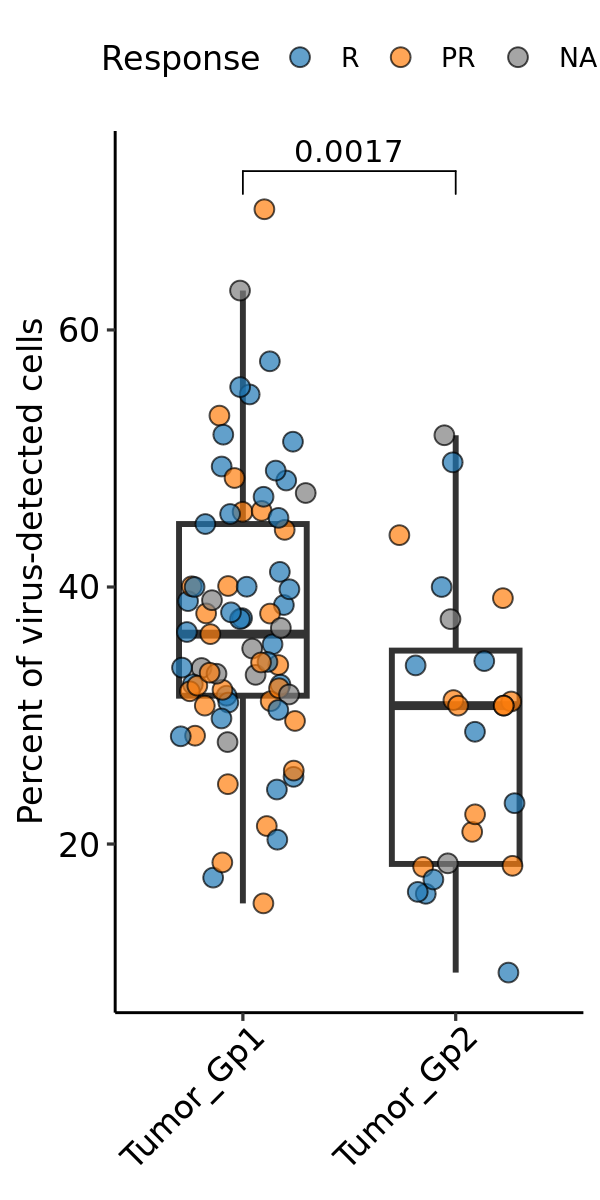

In [134]:
p <- df_stat %>% 
    # filter(!is.na(.data[[gp]])) %>%
    # filter(celltype %in% used_ctypes) %>%
    # mutate(celltype = factor(celltype, used_ctypes)) %>%
    filter(celltype %in% c('Tumor_Gp1', 'Tumor_Gp2')) %>%
    mutate(celltype = factor(celltype, names(ctype_ls))) %>%
    cell_comp_boxplot(x = c('celltype'), y = 'Virus-detected', pt_fill = gp,
                      pair_by = NULL, facet_by = NULL, ncol = 3,
                      xorder = names(ctype_ls), fill_order = gp_lvls[[gp]]) +
    stat_compare_means(comparisons = list(c('Tumor_Gp1', 'Tumor_Gp2'))) +
    labs(y = 'Percent of virus-detected cells', fill = 'Response') +
    theme(axis.title.x = element_blank())
jp_opt(wd = 3, hg = 6, res = 200)
p
# ggsave(filename = str_glue('{outdir}/figs6d-box_cell_pct-virus_detected_cells-epi_group.pdf'), width = 8, height = 5, plot = p)

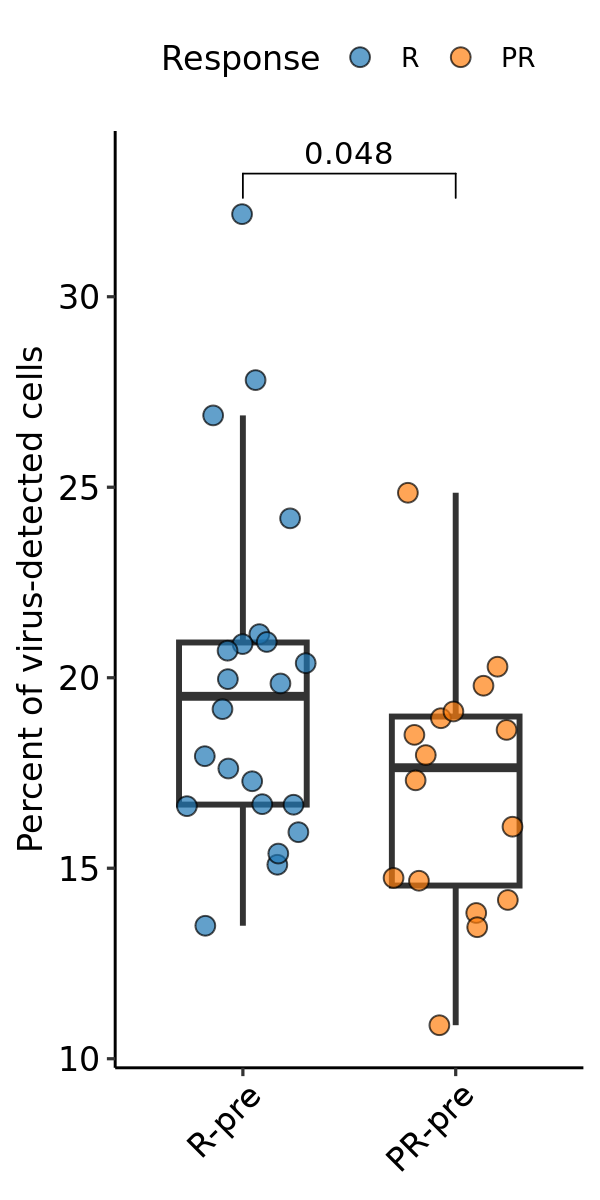

In [141]:
read_tsv(str_glue('{outdir}/fig6c-virus_detection_in_whole-bi-sample_lvl-pct.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>%
    filter(sample_type == 'pre') %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'Virus-detected', pt_fill = gp, pair_by = NULL, 
                      xorder = comb_order, fill_order = gp_lvls[[gp]], facet_by = NULL, ncol = 3) +
    stat_compare_means(comparisons = list(c('R-pre', 'PR-pre'))) +
    labs(y = 'Percent of virus-detected cells', fill = 'Response') +
    theme(axis.title.x = element_blank())